### Import Necessary Modules


In [40]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap.umap_ as umap

In [39]:
# 1. Load and preprocess MNIST dataset (smaller subset)
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Take small subset for quick test and low memory
x_train, y_train = x_train[:10000], y_train[:10000]
x_test, y_test = x_test[:10000], y_test[:10000]

print("Shape of selected images:", x_test.shape)
print("Shape of selected labels:", y_test.shape)

Shape of selected images: (10000, 28, 28)
Shape of selected labels: (10000,)


In [41]:
# Expand dims to (batch, 28, 28, 1), convert to RGB and resize to (96, 96, 3)
def preprocess(images):
    images = tf.expand_dims(images, -1)
    images = tf.image.grayscale_to_rgb(images)
    images = tf.image.resize(images, [96, 96])
    return images / 255.0

In [42]:
x_train = preprocess(x_train).numpy()
x_test = preprocess(x_test).numpy()
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

In [43]:
# 2. Load pretrained MobileNetV2 (ImageNet weights) as feature extractor
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
base_model.trainable = False
model_before = Model(inputs=base_model.input, outputs=GlobalAveragePooling2D()(base_model.output))
# model_before.summary(show_trainable = True)

In [44]:
# Extract features BEFORE transfer learning
features_before = model_before.predict(x_test)

# 3. Fine-tune on MNIST
x_input = Input(shape=(96, 96, 3))
base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x_input)
base.trainable = False
x = GlobalAveragePooling2D()(base.output)
x = Dense(128, activation='relu')(x)
output = Dense(10, activation='softmax')(x)
model_after = Model(inputs=x_input, outputs=output)
model_after.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train with small batch size and fewer epochs
model_after.fit(x_train, y_train_cat, epochs=3, batch_size=32, validation_split=0.1, verbose=2)

# Extract features AFTER transfer learning
feature_extractor_after = Model(inputs=model_after.input, outputs=model_after.layers[-3].output)
features_after = feature_extractor_after.predict(x_test, verbose=1)

313/313 ━━━━━━━━━━━━━━━━━━━━ 73s 208ms/step


C:\Users\Israil\AppData\Local\Temp\ipykernel_14076\2005247865.py:6: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=x_input)


Epoch 1/3
282/282 - 57s - 200ms/step - accuracy: 0.7128 - loss: 0.9970 - val_accuracy: 0.8610 - val_loss: 0.4385
Epoch 2/3
282/282 - 44s - 158ms/step - accuracy: 0.8820 - loss: 0.4006 - val_accuracy: 0.8830 - val_loss: 0.3400
Epoch 3/3
282/282 - 48s - 170ms/step - accuracy: 0.9023 - loss: 0.3164 - val_accuracy: 0.9020 - val_loss: 0.2940
313/313 ━━━━━━━━━━━━━━━━━━━━ 50s 153ms/step


In [37]:
# 4. Dimensionality reduction and plotting
def plot_2d(features, labels, method, title):
    if method == 'PCA':
        reducer = PCA(n_components=2)
    elif method == 't-SNE':
        reducer = TSNE(n_components=2, random_state=42)
    elif method == 'UMAP':
        reducer = umap.UMAP(n_components=2, random_state=42)
    else:
        raise ValueError("Invalid method")

    reduced = reducer.fit_transform(features)
    plt.figure(figsize=(6, 5))
    scatter = plt.scatter(reduced[:, 0], reduced[:, 1], c=labels, cmap='tab10', s=10)
    plt.legend(*scatter.legend_elements(), title="Digits", bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.title(title)
    plt.tight_layout()
    plt.show()

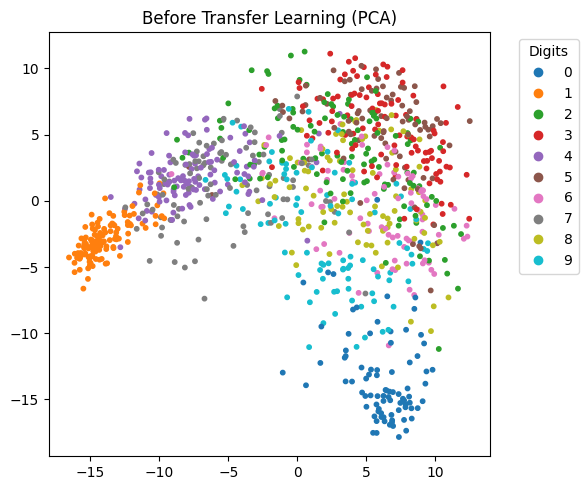

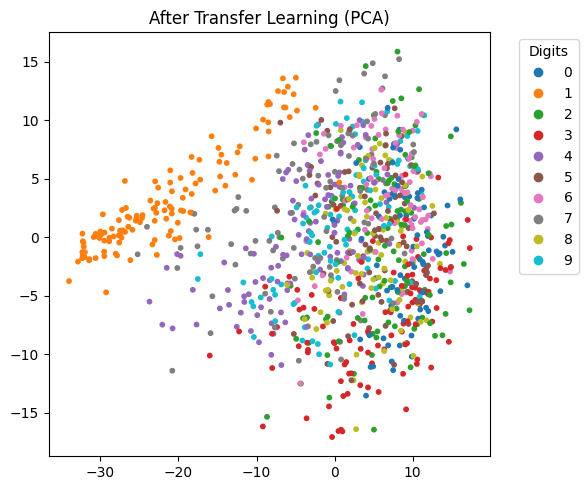

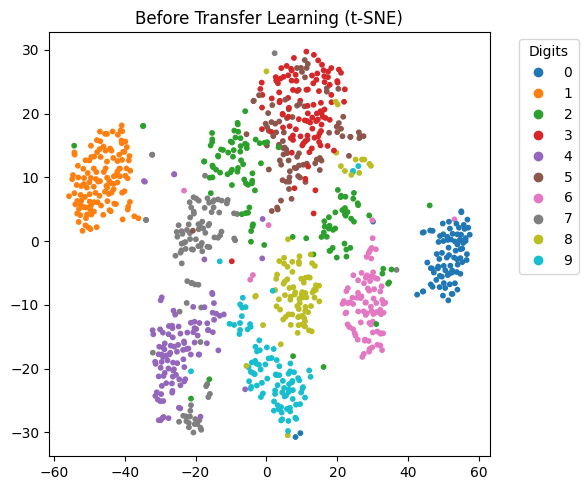

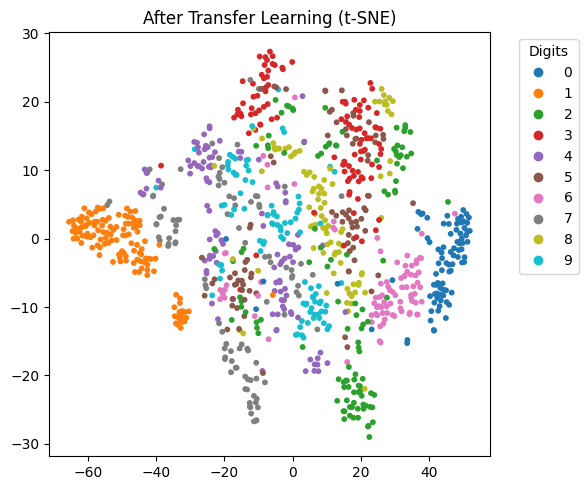

c:\Users\Israil\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


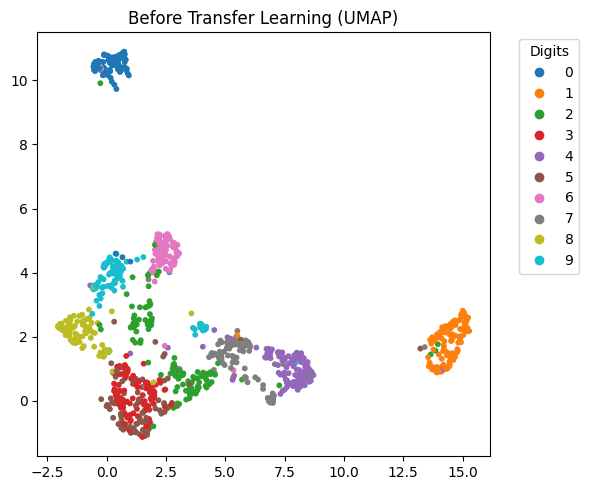

c:\Users\Israil\AppData\Local\Programs\Python\Python312\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


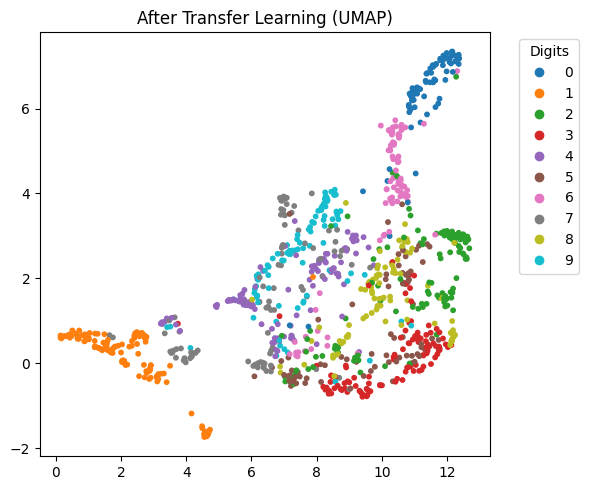

In [38]:
# Plotting for each method
for method in ['PCA', 't-SNE', 'UMAP']:
    plot_2d(features_before, y_test, method, f"Before Transfer Learning ({method})")
    plot_2d(features_after, y_test, method, f"After Transfer Learning ({method})")
